In [ ]:
#################################################################################################
#####################  Assignment 3 MSDS 458 - Analyze AG_News ##################################
#########################      AUthor: Siyuan Liu      ##########################################
##########################   Date: 2022/2/14   ##################################################
#################################################################################################

In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


### Functions For Research Assignment 

In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Loading AG TensorFlow Dataset

In [ ]:
#register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

2022-02-18 17:57:58.413060: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0218 17:57:58.413396 139969180387200 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0218 17:57:59.040838 139969180387200 dataset_info.py:434] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ag_news_subset/1.0.0
I0218 17:58:00.151570 139969180387200 dataset_info.py:361] Load dataset info from /tmp/tmprve248p7tfds
I0218 17:58:00.153592 139969180387200 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0218 17:58:00.153996 139969180387200 dataset_builder.py:357] Generating dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]I0218 17:58:00.695875 139969180387200 download_manager.py:476] 

###  Exploratory Analysis AG News Subset

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [ ]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


In [ ]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
# classes dictionary
categories =dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

In [ ]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

In [ ]:
%%time
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None)
encoder.adapt(dataset_all.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

Cause: could not parse the source code of <function <lambda> at 0x7f235ece9c20>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f235ece9c20>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f235ece9c20>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 2min 1s, sys: 16.2 s, total: 2min 17s
Wall time: 1min 42s


In [ ]:
print(f"There are {len(vocab)} vocabulary words in the corpus.")

There are 95976 vocabulary words in the corpus.


In [ ]:
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U150')

In [ ]:
%%time
doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = encoder(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

CPU times: user 8min 27s, sys: 9.92 s, total: 8min 37s
Wall time: 8min 8s


In [ ]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 3909695 words in the corpus of 127600 news articles.
Each news article has between 3 and 173 tokens in it.


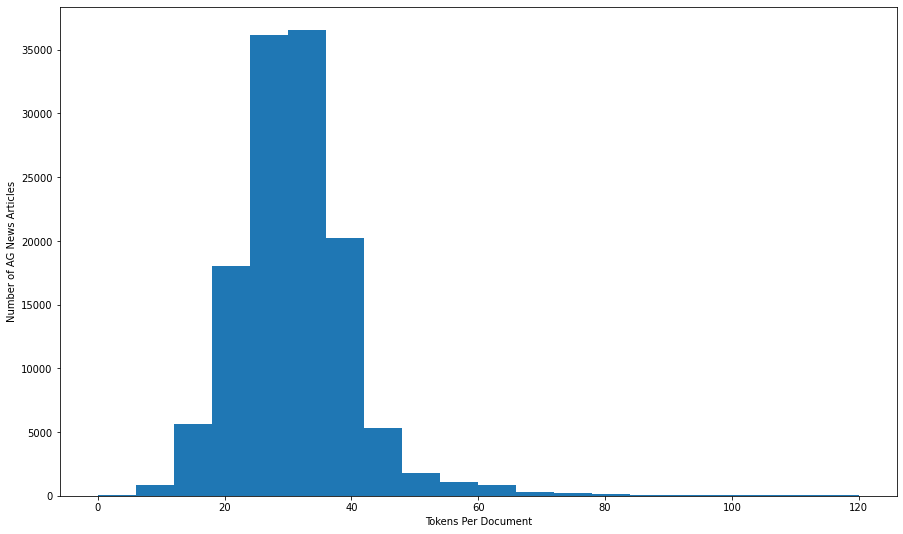

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

In [ ]:
%%time
encoder_1000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000)
encoder_1000.adapt(dataset_all.map(lambda text, label: text))
vocab_1000 = np.array(encoder_1000.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7f2357c79e60>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f2357c79e60>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f2357c79e60>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 57s, sys: 15.1 s, total: 2min 12s
Wall time: 2min 22s


In [ ]:
vocab_1000[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

In [ ]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
encoder_1000(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([  2,   1,   1,  29,   3, 232,   1,  14,  19,   1,  18,   2,   1,
         8,   2, 999])>

In [ ]:
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab_1000  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is *not* in the vocabulary.
"ran" is *not* in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is *not* in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is *not* in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is *not* in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


In [ ]:
%%time
doc1000_sizes = []
corpus1000 = []
count1000=0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_1000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 9min 53s, sys: 11.1 s, total: 10min 4s
Wall time: 9min 34s


In [ ]:
print(f"Each news article has between {min(doc1000_sizes)} and {max(doc1000_sizes)} tokens in it.")

Each news article has between 3 and 173 tokens in it.


### Preprocessing Data Create Input Pipeline

In [ ]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2022-02-18 18:20:54.213010: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0218 18:20:54.213254 140127309649792 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0218 18:20:54.214304 140127309649792 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0218 18:20:54.215709 140127309649792 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0218 18:20:54.215921 140127309649792 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.\nComeToMyHead is an academic news search engine which has been running since July, 2004.\nThe dataset is 

In [ ]:
len(train_dataset),len(validation_dataset),len(test_dataset) 
# len(train_dataset),len(test_dataset) 

(114000, 6000, 7600)

### Review Distribution of Categorical Labels for the 114000 training data (news articles)

In [ ]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(2): #take() Creates a Dataset with at most count elements from this dataset, so it returns the data elements (since it's been batched/bundled 64 instances per element)
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Reuters - Google Inc.'s GOOG.O initial\\public offering of 19.6 million shares priced at  #36;85 each, the\\low end of their projected range, a source familiar with the\\auction said on Wednesday, raising  #36;1.67 billion and making it\\the fourth-largest U.S. IPO this year."
 b'The High Court ruled on 6 December in favour of the three banks which own 75 per cent of F1 #39;s commercial rights being permitted to appoint directors to Formula One Holdings.'
 b"Peter Hartz, as chairman of a commission to overhaul Germany's economy, became synonymous with far-reaching, often unpopular, reforms."]

labels:  [2 1 2]
texts:  [b' NEW YORK (Billboard) - The next wave of iPod competitors is  coming.'
 b'LONDON (England): Pakistan coach Bob Woolmer said his side were in desperate need of a match-winner after losing to Australia in their one-day warm-up match at Lords.'
 b'If you #39;re a Nokia smart phone user, better pay attention...come to think of it, better pay attention even if yo

In [ ]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b'Reuters - First-day sales of Microsoft\\Corp.\'s  new video game "Halo 2" will reach  #36;100\\million, a senior Microsoft games executive said on Tuesday.'
 b'Reuters - U.S. presidents past and present\\appealed to Americans on Monday to help victims of the Asian\\tsunami as one of the biggest aid efforts in history struggled\\to bring food and water to millions of desperate survivors.'
 b'Colombo: Norway #39;s latest bid to salvage Sri Lanka #39;s faltering peace process ended without a breakthrough Friday but the government and the rebels have pledged to continue to uphold a fragile truce.']

labels:  ['Sci/Tech', 'World', 'World']

texts:  [b'Security researchers have discovered another vulnerability in Windows XP Service Pack 2, but it doesn #39;t appear to be an immediate threat.'
 b'For years, Continental Europeans have chastised the British for what they regard as a lack of European credentials. The British, other Europeans complain, stand outside the '
 b'BMC Softwa

# **Experiment A - EDA**

## Create the Text Encoder

1. tweek the vocabulary size of encoder
2. Vocabulary customization
3. output sequence length

In [ ]:
# encoder 1 - 1000 vocabulary size, no edit of vocabulary, default output sequence length
encoder1 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=1000)
encoder1.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder1.get_vocabulary())
len(vocab)

1000

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:100]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it',
       'has', 'new', 'an', 'from', 'his', 'us', 'will', 'was', 'reuters',
       'after', 'have', 'be', 'their', 'are', 'over', 'ap', 'he', 'but',
       'two', 'first', 'this', 'more', 'monday', 'wednesday', 'tuesday',
       'thursday', 'company', 'up', 'friday', 'inc', 'one', 'world',
       'they', 'yesterday', 'last', 'york', 'against', 'than', 'who',
       'about', 'were', 'not', 'into', 'year', 'been', 'out', 'president',
       'had', 'when', 'million', 'oil', 'corp', 'united', 'would',
       'sunday', 'years', 'week', 'which', 'people', 'today', 'three',
       'government', 'could', 'quot', 'group', 'time', 'no', 'percent',
       'game', 'saturday', 'software', 'night', 'next', 'prices', 'or',
       'iraq', 'security', 'announced', 'minister', 'microsoft'],
      dtype='<U150')

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

def edit_vocab(tokens): 
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    return tokens

In [ ]:
vocab_new = edit_vocab(vocab)
print(vocab_new[:20])

['[UNK]', 'reuters', 'first', 'monday', 'wednesday', 'tuesday', 'thursday', 'company', 'friday', 'world', 'yesterday', 'president', 'million', 'united', 'would', 'sunday', 'years', 'people', 'today', 'three']


In [ ]:
# encoder 2 - 1000 vocabulary size, no edit of vocabulary, arbitary output sequence length
encoder2 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=1000, output_sequence_length=128)
encoder2.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
# encoder 3 - 1000 vocabulary size, customized vocabulary by removing stopwords, default output sequence length
encoder3 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=1000, vocabulary = vocab_new[0:998])

In [ ]:
# encoder 4 - 1000 vocabulary size, customized vocabulary by removing stopwords, arbitary output sequence length
encoder4 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=1000, output_sequence_length=128, vocabulary = vocab_new[0:998])

In [ ]:
# encoder 5 - 2000 vocabulary size, no edit of vocabulary, default output sequence length
encoder5 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=2000)
encoder5.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
# encoder 6 - 2000 vocabulary size, no edit of vocabulary, arbitary output sequence length
encoder6 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=2000, output_sequence_length=128)
encoder6.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
# encoder 7 - 2000 vocabulary size, customized vocabulary by removing stopwords, default output sequence length
encoder7 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=2000, vocabulary = vocab_new[0:1998])

In [ ]:
# encoder 8 - 2000 vocabulary size, customized vocabulary by removing stopwords, arbitary output sequence length
encoder8 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=2000, output_sequence_length=128, vocabulary = vocab_new[0:1998])

In [ ]:
# encoder 9 - 3000 vocabulary size, no edit of vocabulary, default output sequence length
encoder9 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=3000)
encoder9.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
# encoder 10 - 3000 vocabulary size, no edit of vocabulary, arbitary output sequence length
encoder10 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=3000, output_sequence_length=128)
encoder10.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
# encoder 11 - 3000 vocabulary size, customized vocabulary by removing stopwords, default output sequence length
encoder11 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=3000, vocabulary = vocab_new[0:2998])

In [ ]:
# encoder 12 - 3000 vocabulary size, customized vocabulary by removing stopwords, arbitary output sequence length
encoder12 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=3000, output_sequence_length=128, vocabulary = vocab_new[0:2998])

Here are the 20 least frequent words.

In [ ]:
vocab[-20:]

array(['0133', '0125', '0121', '012', '011micron', '0119', '01112004',
       '011104', '01102004', '011', '0100', '008s', '007percent', '007',
       '005', '004', '0013', '000th', '000strong', '000660se'],
      dtype='<U150')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[   96,   780,    30,  1478,   185,  4089,     6,   317,  1116,
          138,  1816,   245,    37,    19,  2247,   200,  2131,     4,
           31,    22,  2838,   920,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    9,    75,  5458,  5888,    30, 17171,     2,   182,     9,
          154,    52, 11893,    14,     3,  2448,     5,   132,  8626,
            2,   182,   124,  5888,  8481,  1673,   671,     2,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [18238,    90,    16,   199,     4,  1374,  5604,     4,    38,
            5,    13,   318,   471,   384,     8,    42,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Security researchers have discovered another vulnerability in Windows XP Service Pack 2, but it doesn #39;t appear to be an immediate threat.'
Round-trip:  security researchers have discovered another vulnerability in windows xp service pack 2 but it doesn 39t appear to be an immediate threat                          

Original:  b'For years, Continental Europeans have chastised the British for what they regard as a lack of European credentials. The British, other Europeans complain, stand outside the '
Round-trip:  for years continental europeans have chastised the british for what they regard as a lack of european credentials the british other europeans complain stand outside the                      

Original:  b'BMC Software is expected to announce upgrades to two of its systems management products on Monday.'
Round-trip:  bmc software is expected to announce upgrades to two of its systems management products on monday                                



## Create the Model based on 12 encoders with everything else remaining the same

In [ ]:
num_classes = 4
model1 = tf.keras.Sequential([
                              encoder1
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

## Compile Model 

In [ ]:
model1.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          6142464   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 6,217,028
Trainable params: 6,217,028
Non-

## Model Trainning

In [ ]:
history1 = model1.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 229s 124ms/step - loss: 0.7477 - accuracy: 0.6938 - val_loss: 0.4815 - val_accuracy: 0.8332
Epoch 2/200
1782/1782 [==============================] - 218s 123ms/step - loss: 0.4524 - accuracy: 0.8390 - val_loss: 0.4297 - val_accuracy: 0.8482
Epoch 3/200
1782/1782 [==============================] - 217s 122ms/step - loss: 0.4108 - accuracy: 0.8515 - val_loss: 0.4003 - val_accuracy: 0.8583
Epoch 4/200
1782/1782 [==============================] - 216s 121ms/step - loss: 0.3936 - accuracy: 0.8565 - val_loss: 0.3985 - val_accuracy: 0.8567
Epoch 5/200
1782/1782 [==============================] - 214s 120ms/step - loss: 0.3860 - accuracy: 0.8587 - val_loss: 0.3948 - val_accuracy: 0.8570


In [ ]:
test_loss, test_acc = model1.evaluate(test_dataset)

119/119 [==============================] - 3s 26ms/step - loss: 0.4133 - accuracy: 0.8474


## Plotting Performance Metrics - Single Layer Bidirectional RNN

In [ ]:
history_dict = history1.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.748,0.694,0.482,0.833
1,0.452,0.839,0.430,0.848
2,0.411,0.852,0.400,0.858
3,0.394,0.857,0.398,0.857
4,0.386,0.859,0.395,0.857


In [ ]:
losses = history1.history['loss']
accs = history1.history['accuracy']
val_losses = history1.history['val_loss']
val_accs = history1.history['val_accuracy']
epochs = len(losses)

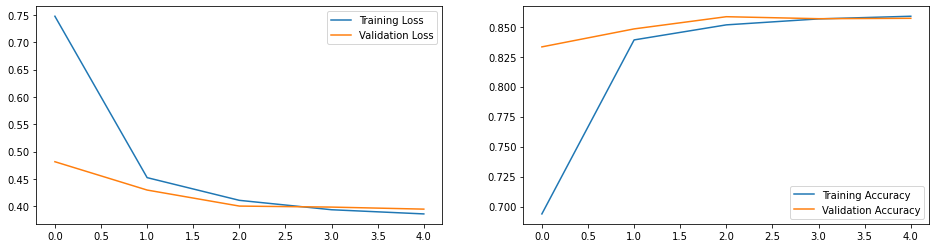

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy = []
test_accuracy.append(test_acc)

In [ ]:
## create model with endcoder 2

In [ ]:
num_classes = 4
model2 = tf.keras.Sequential([
                              encoder2
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 352s 193ms/step - loss: 0.6668 - accuracy: 0.7510 - val_loss: 0.4771 - val_accuracy: 0.8330
Epoch 2/200
1782/1782 [==============================] - 340s 190ms/step - loss: 0.4330 - accuracy: 0.8463 - val_loss: 0.4166 - val_accuracy: 0.8562
Epoch 3/200
1782/1782 [==============================] - 340s 191ms/step - loss: 0.4078 - accuracy: 0.8535 - val_loss: 0.4140 - val_accuracy: 0.8510
Epoch 4/200
1782/1782 [==============================] - 341s 191ms/step - loss: 0.3943 - accuracy: 0.8579 - val_loss: 0.3981 - val_accuracy: 0.8557


In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

119/119 [==============================] - 5s 40ms/step - loss: 0.4154 - accuracy: 0.8493


In [ ]:
history_dict = history2.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.667,0.751,0.477,0.833
1,0.433,0.846,0.417,0.856
2,0.408,0.853,0.414,0.851
3,0.394,0.858,0.398,0.856


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

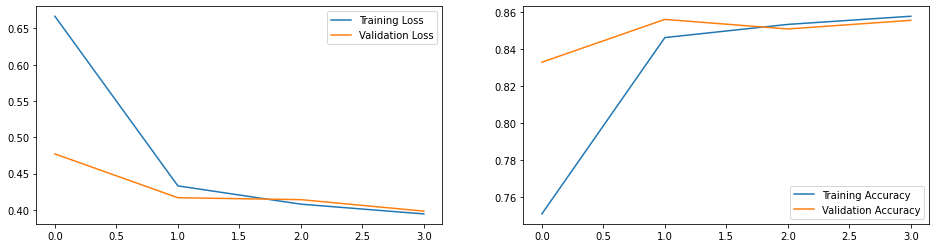

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
## create model with endcoder 3

In [ ]:
num_classes = 4
model3 = tf.keras.Sequential([
                              encoder3
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model3.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 229s 123ms/step - loss: 0.7773 - accuracy: 0.7063 - val_loss: 0.5304 - val_accuracy: 0.8192
Epoch 2/200
1782/1782 [==============================] - 217s 122ms/step - loss: 0.5053 - accuracy: 0.8199 - val_loss: 0.4809 - val_accuracy: 0.8317
Epoch 3/200
1782/1782 [==============================] - 218s 122ms/step - loss: 0.4605 - accuracy: 0.8351 - val_loss: 0.4506 - val_accuracy: 0.8367
Epoch 4/200
1782/1782 [==============================] - 217s 122ms/step - loss: 0.4397 - accuracy: 0.8409 - val_loss: 0.4472 - val_accuracy: 0.8378
Epoch 5/200
1782/1782 [==============================] - 215s 121ms/step - loss: 0.4290 - accuracy: 0.8441 - val_loss: 0.4442 - val_accuracy: 0.8348
Epoch 6/200
1782/1782 [==============================] - 217s 122ms/step - loss: 0.4233 - accuracy: 0.8460 - val_loss: 0.4371 - val_accuracy: 0.8390
Epoch 7/200
1782/1782 [==============================] - 218s 122ms/step - loss: 0.4179 - accuracy: 0.8474

In [ ]:
test_loss, test_acc = model3.evaluate(test_dataset)

119/119 [==============================] - 3s 25ms/step - loss: 0.4360 - accuracy: 0.8461


In [ ]:
history_dict = history3.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.777,0.706,0.530,0.819
1,0.505,0.820,0.481,0.832
2,0.460,0.835,0.451,0.837
3,0.440,0.841,0.447,0.838
4,0.429,0.844,0.444,0.835
5,0.423,0.846,0.437,0.839
6,0.418,0.847,0.431,0.840
7,0.414,0.848,0.431,0.840
8,0.411,0.850,0.436,0.840


In [ ]:
losses = history3.history['loss']
accs = history3.history['accuracy']
val_losses = history3.history['val_loss']
val_accs = history3.history['val_accuracy']
epochs = len(losses)

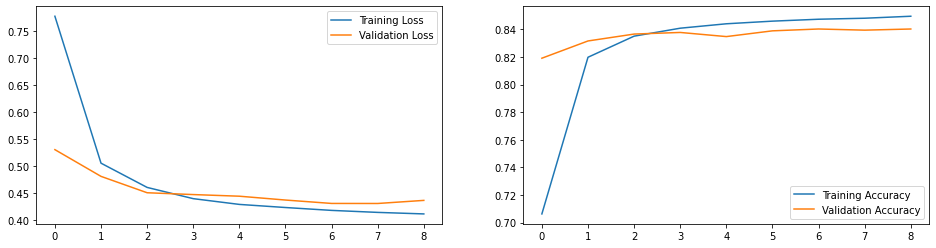

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
## create model with endcoder 4

In [ ]:
num_classes = 4
model4 = tf.keras.Sequential([
                              encoder2
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model4.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 352s 193ms/step - loss: 0.7756 - accuracy: 0.6980 - val_loss: 0.5237 - val_accuracy: 0.8202
Epoch 2/200
1782/1782 [==============================] - 342s 192ms/step - loss: 0.4787 - accuracy: 0.8304 - val_loss: 0.4501 - val_accuracy: 0.8457
Epoch 3/200
1782/1782 [==============================] - 342s 192ms/step - loss: 0.4477 - accuracy: 0.8409 - val_loss: 0.4409 - val_accuracy: 0.8482
Epoch 4/200
1782/1782 [==============================] - 344s 193ms/step - loss: 0.4287 - accuracy: 0.8469 - val_loss: 0.4206 - val_accuracy: 0.8517
Epoch 5/200
1782/1782 [==============================] - 344s 193ms/step - loss: 0.4099 - accuracy: 0.8534 - val_loss: 0.4053 - val_accuracy: 0.8610
Epoch 6/200
1782/1782 [==============================] - 349s 196ms/step - loss: 0.3962 - accuracy: 0.8571 - val_loss: 0.3913 - val_accuracy: 0.8625
Epoch 7/200
1782/1782 [==============================] - 346s 194ms/step - loss: 0.3875 - accuracy: 0.8599

In [ ]:
test_loss, test_acc = model4.evaluate(test_dataset)

119/119 [==============================] - 5s 40ms/step - loss: 0.4085 - accuracy: 0.8538


In [ ]:
history_dict = history4.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.776,0.698,0.524,0.820
1,0.479,0.830,0.450,0.846
2,0.448,0.841,0.441,0.848
3,0.429,0.847,0.421,0.852
4,0.410,0.853,0.405,0.861
5,0.396,0.857,0.391,0.863
6,0.388,0.860,0.389,0.862
7,0.382,0.861,0.393,0.861


In [ ]:
losses = history4.history['loss']
accs = history4.history['accuracy']
val_losses = history4.history['val_loss']
val_accs = history4.history['val_accuracy']
epochs = len(losses)

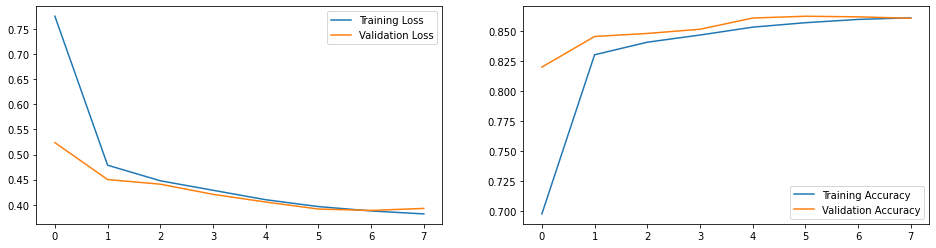

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
## create model with endcoder 5

In [ ]:
num_classes = 4
model5 = tf.keras.Sequential([
                              encoder5
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model5.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
print([layer.supports_masking for layer in model5.layers])

[False, True, True, True, True]


In [ ]:
history5 = model5.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 231s 125ms/step - loss: 0.6270 - accuracy: 0.7631 - val_loss: 0.4258 - val_accuracy: 0.8562
Epoch 2/200
1782/1782 [==============================] - 220s 124ms/step - loss: 0.3923 - accuracy: 0.8630 - val_loss: 0.3999 - val_accuracy: 0.8598
Epoch 3/200
1782/1782 [==============================] - 224s 125ms/step - loss: 0.3640 - accuracy: 0.8724 - val_loss: 0.3686 - val_accuracy: 0.8722
Epoch 4/200
1782/1782 [==============================] - 220s 124ms/step - loss: 0.3458 - accuracy: 0.8780 - val_loss: 0.3538 - val_accuracy: 0.8768
Epoch 5/200
1782/1782 [==============================] - 223s 125ms/step - loss: 0.3294 - accuracy: 0.8828 - val_loss: 0.3546 - val_accuracy: 0.8723
Epoch 6/200
1782/1782 [==============================] - 220s 123ms/step - loss: 0.3159 - accuracy: 0.8877 - val_loss: 0.3413 - val_accuracy: 0.8777
Epoch 7/200
1782/1782 [==============================] - 224s 126ms/step - loss: 0.3064 - accuracy: 0.8909

In [ ]:
test_loss, test_acc = model5.evaluate(test_dataset)

119/119 [==============================] - 3s 25ms/step - loss: 0.3343 - accuracy: 0.8796


In [ ]:
history_dict = history5.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
2,0.364,0.872,0.369,0.872
3,0.346,0.878,0.354,0.877
4,0.329,0.883,0.355,0.872
5,0.316,0.888,0.341,0.878
6,0.306,0.891,0.344,0.881
7,0.300,0.893,0.332,0.882
8,0.295,0.895,0.332,0.883
9,0.289,0.897,0.332,0.884
10,0.284,0.899,0.330,0.883
11,0.280,0.900,0.330,0.882


In [ ]:
losses = history5.history['loss']
accs = history5.history['accuracy']
val_losses = history5.history['val_loss']
val_accs = history5.history['val_accuracy']
epochs = len(losses)

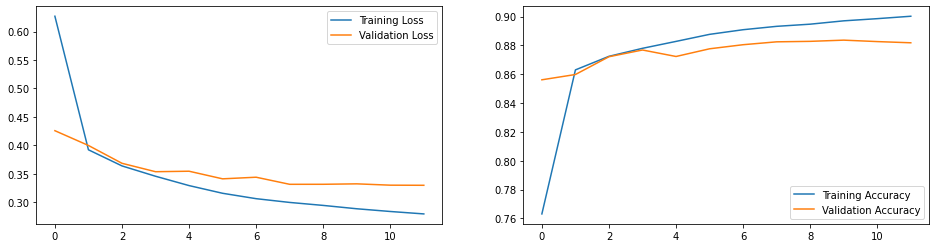

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
## create model with endcoder 6

In [ ]:
num_classes = 4
model6 = tf.keras.Sequential([
                              encoder6
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model6.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history6 = model6.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 364s 199ms/step - loss: 0.6923 - accuracy: 0.7338 - val_loss: 0.4278 - val_accuracy: 0.8560
Epoch 2/200
1782/1782 [==============================] - 357s 200ms/step - loss: 0.3998 - accuracy: 0.8607 - val_loss: 0.3854 - val_accuracy: 0.8692
Epoch 3/200
1782/1782 [==============================] - 349s 196ms/step - loss: 0.3627 - accuracy: 0.8730 - val_loss: 0.3622 - val_accuracy: 0.8745
Epoch 4/200
1782/1782 [==============================] - 343s 193ms/step - loss: 0.3379 - accuracy: 0.8815 - val_loss: 0.3583 - val_accuracy: 0.8757
Epoch 5/200
1782/1782 [==============================] - 344s 193ms/step - loss: 0.3228 - accuracy: 0.8856 - val_loss: 0.3442 - val_accuracy: 0.8817
Epoch 6/200
1782/1782 [==============================] - 345s 193ms/step - loss: 0.3124 - accuracy: 0.8889 - val_loss: 0.3412 - val_accuracy: 0.8783
Epoch 7/200
1782/1782 [==============================] - 344s 193ms/step - loss: 0.3057 - accuracy: 0.8911

In [ ]:
test_loss, test_acc = model6.evaluate(test_dataset)

119/119 [==============================] - 5s 40ms/step - loss: 0.3417 - accuracy: 0.8787


In [ ]:
history_dict = history6.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.692,0.734,0.428,0.856
1,0.400,0.861,0.385,0.869
2,0.363,0.873,0.362,0.874
3,0.338,0.882,0.358,0.876
4,0.323,0.886,0.344,0.882
5,0.312,0.889,0.341,0.878
6,0.306,0.891,0.339,0.880


In [ ]:
losses = history6.history['loss']
accs = history6.history['accuracy']
val_losses = history6.history['val_loss']
val_accs = history6.history['val_accuracy']
epochs = len(losses)

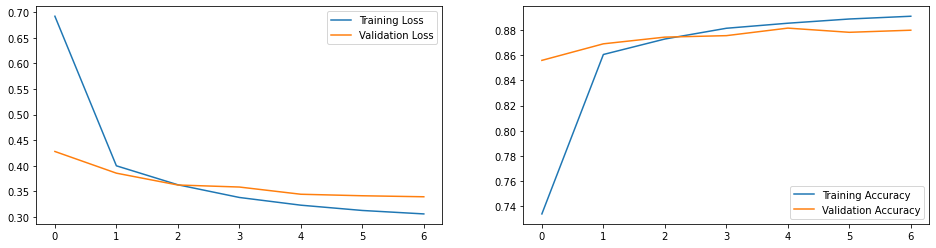

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
## create model with endcoder 2

In [ ]:
num_classes = 4
model7 = tf.keras.Sequential([
                              encoder7
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model7.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history7 = model7.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 232s 125ms/step - loss: 0.7439 - accuracy: 0.7133 - val_loss: 0.5257 - val_accuracy: 0.8183
Epoch 2/200
1782/1782 [==============================] - 222s 124ms/step - loss: 0.4452 - accuracy: 0.8458 - val_loss: 0.4394 - val_accuracy: 0.8473
Epoch 3/200
1782/1782 [==============================] - 220s 124ms/step - loss: 0.4120 - accuracy: 0.8564 - val_loss: 0.4302 - val_accuracy: 0.8510
Epoch 4/200
1782/1782 [==============================] - 221s 124ms/step - loss: 0.3943 - accuracy: 0.8623 - val_loss: 0.4147 - val_accuracy: 0.8557
Epoch 5/200
1782/1782 [==============================] - 222s 124ms/step - loss: 0.3824 - accuracy: 0.8652 - val_loss: 0.3986 - val_accuracy: 0.8623
Epoch 6/200
1782/1782 [==============================] - 220s 123ms/step - loss: 0.3697 - accuracy: 0.8698 - val_loss: 0.4058 - val_accuracy: 0.8578
Epoch 7/200
1782/1782 [==============================] - 220s 123ms/step - loss: 0.3578 - accuracy: 0.8743

In [ ]:
test_loss, test_acc = model7.evaluate(test_dataset)

119/119 [==============================] - 3s 27ms/step - loss: 0.4017 - accuracy: 0.8572


In [ ]:
history_dict = history7.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.744,0.713,0.526,0.818
1,0.445,0.846,0.439,0.847
2,0.412,0.856,0.430,0.851
3,0.394,0.862,0.415,0.856
4,0.382,0.865,0.399,0.862
5,0.370,0.870,0.406,0.858
6,0.358,0.874,0.403,0.861


In [ ]:
losses = history7.history['loss']
accs = history7.history['accuracy']
val_losses = history7.history['val_loss']
val_accs = history7.history['val_accuracy']
epochs = len(losses)

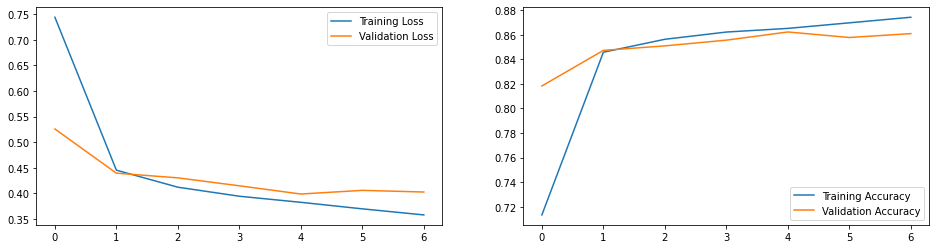

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
## create model with endcoder 8

In [ ]:
num_classes = 4
model8 = tf.keras.Sequential([
                              encoder8
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model8.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history8 = model8.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 364s 198ms/step - loss: 0.8252 - accuracy: 0.6781 - val_loss: 0.5558 - val_accuracy: 0.8043
Epoch 2/200
1782/1782 [==============================] - 345s 194ms/step - loss: 0.4751 - accuracy: 0.8335 - val_loss: 0.4482 - val_accuracy: 0.8427
Epoch 3/200
1782/1782 [==============================] - 348s 195ms/step - loss: 0.4149 - accuracy: 0.8556 - val_loss: 0.4096 - val_accuracy: 0.8552
Epoch 4/200
1782/1782 [==============================] - 350s 196ms/step - loss: 0.3838 - accuracy: 0.8669 - val_loss: 0.4035 - val_accuracy: 0.8550
Epoch 5/200
1782/1782 [==============================] - 348s 195ms/step - loss: 0.3637 - accuracy: 0.8719 - val_loss: 0.3843 - val_accuracy: 0.8615
Epoch 6/200
1782/1782 [==============================] - 348s 195ms/step - loss: 0.3536 - accuracy: 0.8747 - val_loss: 0.3888 - val_accuracy: 0.8578
Epoch 7/200
1782/1782 [==============================] - 349s 196ms/step - loss: 0.3458 - accuracy: 0.8776

In [ ]:
test_loss, test_acc = model8.evaluate(test_dataset)

119/119 [==============================] - 5s 43ms/step - loss: 0.3818 - accuracy: 0.8655


In [ ]:
history_dict = history8.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.825,0.678,0.556,0.804
1,0.475,0.833,0.448,0.843
2,0.415,0.856,0.410,0.855
3,0.384,0.867,0.404,0.855
4,0.364,0.872,0.384,0.862
5,0.354,0.875,0.389,0.858
6,0.346,0.878,0.393,0.862
7,0.340,0.879,0.377,0.865
8,0.336,0.881,0.381,0.862
9,0.333,0.881,0.380,0.863


In [ ]:
losses = history8.history['loss']
accs = history8.history['accuracy']
val_losses = history8.history['val_loss']
val_accs = history8.history['val_accuracy']
epochs = len(losses)

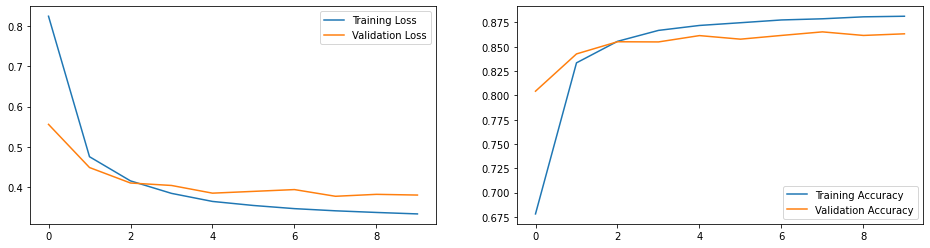

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
## create model with endcoder 9

In [ ]:
num_classes = 4
model9 = tf.keras.Sequential([
                              encoder9
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model9.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history9 = model9.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 228s 124ms/step - loss: 0.6485 - accuracy: 0.7584 - val_loss: 0.4060 - val_accuracy: 0.8637
Epoch 2/200
1782/1782 [==============================] - 217s 122ms/step - loss: 0.3707 - accuracy: 0.8732 - val_loss: 0.3663 - val_accuracy: 0.8752
Epoch 3/200
1782/1782 [==============================] - 218s 122ms/step - loss: 0.3296 - accuracy: 0.8869 - val_loss: 0.3411 - val_accuracy: 0.8833
Epoch 4/200
1782/1782 [==============================] - 218s 122ms/step - loss: 0.3035 - accuracy: 0.8949 - val_loss: 0.3220 - val_accuracy: 0.8878
Epoch 5/200
1782/1782 [==============================] - 218s 122ms/step - loss: 0.2884 - accuracy: 0.8980 - val_loss: 0.3205 - val_accuracy: 0.8877
Epoch 6/200
1782/1782 [==============================] - 217s 122ms/step - loss: 0.2776 - accuracy: 0.9026 - val_loss: 0.3192 - val_accuracy: 0.8863


In [ ]:
test_loss, test_acc = model9.evaluate(test_dataset)

119/119 [==============================] - 3s 24ms/step - loss: 0.3240 - accuracy: 0.8857


In [ ]:
history_dict = history9.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.648,0.758,0.406,0.864
1,0.371,0.873,0.366,0.875
2,0.330,0.887,0.341,0.883
3,0.303,0.895,0.322,0.888
4,0.288,0.898,0.321,0.888
5,0.278,0.903,0.319,0.886


In [ ]:
losses = history9.history['loss']
accs = history9.history['accuracy']
val_losses = history9.history['val_loss']
val_accs = history9.history['val_accuracy']
epochs = len(losses)

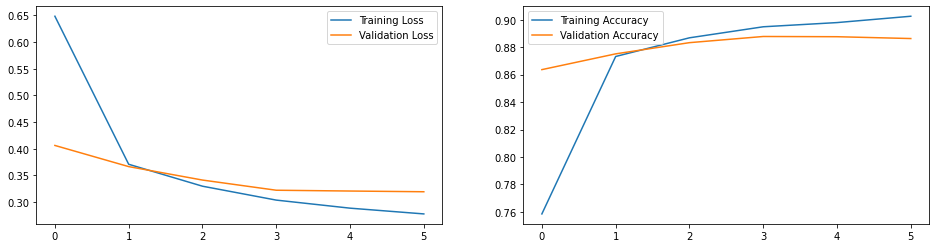

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
## create model with endcoder 10

In [ ]:
num_classes = 4
model10 = tf.keras.Sequential([
                              encoder10
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model10.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history10 = model10.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 365s 200ms/step - loss: 0.6307 - accuracy: 0.7753 - val_loss: 0.3758 - val_accuracy: 0.8730
Epoch 2/200
1782/1782 [==============================] - 351s 197ms/step - loss: 0.3391 - accuracy: 0.8838 - val_loss: 0.3277 - val_accuracy: 0.8877
Epoch 3/200
1782/1782 [==============================] - 348s 195ms/step - loss: 0.3023 - accuracy: 0.8947 - val_loss: 0.3235 - val_accuracy: 0.8887
Epoch 4/200
1782/1782 [==============================] - 349s 196ms/step - loss: 0.2855 - accuracy: 0.8997 - val_loss: 0.3126 - val_accuracy: 0.8920
Epoch 5/200
1782/1782 [==============================] - 347s 195ms/step - loss: 0.2758 - accuracy: 0.9026 - val_loss: 0.3192 - val_accuracy: 0.8872
Epoch 6/200
1782/1782 [==============================] - 349s 196ms/step - loss: 0.2690 - accuracy: 0.9041 - val_loss: 0.3166 - val_accuracy: 0.8867


In [ ]:
test_loss, test_acc = model10.evaluate(test_dataset)

119/119 [==============================] - 5s 40ms/step - loss: 0.3226 - accuracy: 0.8862


In [ ]:
history_dict = history10.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.631,0.775,0.376,0.873
1,0.339,0.884,0.328,0.888
2,0.302,0.895,0.323,0.889
3,0.285,0.900,0.313,0.892
4,0.276,0.903,0.319,0.887
5,0.269,0.904,0.317,0.887


In [ ]:
losses = history10.history['loss']
accs = history10.history['accuracy']
val_losses = history10.history['val_loss']
val_accs = history10.history['val_accuracy']
epochs = len(losses)

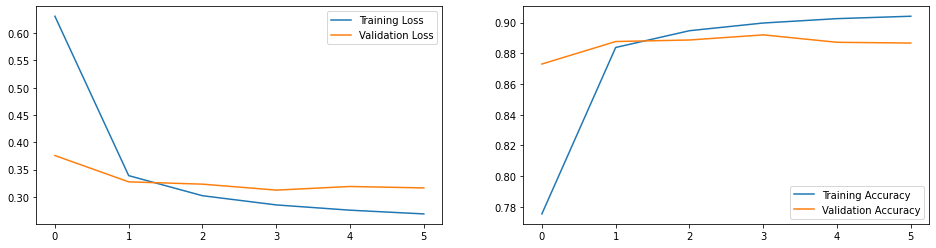

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
## create model with endcoder 11

In [ ]:
num_classes = 4
model11 = tf.keras.Sequential([
                              encoder11
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model11.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history11 = model11.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 236s 127ms/step - loss: 0.7808 - accuracy: 0.7033 - val_loss: 0.4986 - val_accuracy: 0.8367
Epoch 2/200
1782/1782 [==============================] - 224s 126ms/step - loss: 0.4268 - accuracy: 0.8569 - val_loss: 0.4009 - val_accuracy: 0.8665
Epoch 3/200
1782/1782 [==============================] - 223s 125ms/step - loss: 0.3653 - accuracy: 0.8750 - val_loss: 0.3684 - val_accuracy: 0.8755
Epoch 4/200
1782/1782 [==============================] - 223s 125ms/step - loss: 0.3375 - accuracy: 0.8834 - val_loss: 0.3733 - val_accuracy: 0.8725
Epoch 5/200
1782/1782 [==============================] - 225s 126ms/step - loss: 0.3235 - accuracy: 0.8869 - val_loss: 0.3576 - val_accuracy: 0.8765
Epoch 6/200
1782/1782 [==============================] - 224s 126ms/step - loss: 0.3131 - accuracy: 0.8899 - val_loss: 0.3510 - val_accuracy: 0.8775
Epoch 7/200
1782/1782 [==============================] - 224s 126ms/step - loss: 0.3059 - accuracy: 0.8930

In [ ]:
test_loss, test_acc = model11.evaluate(test_dataset)

119/119 [==============================] - 3s 28ms/step - loss: 0.3507 - accuracy: 0.8778


In [ ]:
history_dict = history11.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.781,0.703,0.499,0.837
1,0.427,0.857,0.401,0.867
2,0.365,0.875,0.368,0.876
3,0.338,0.883,0.373,0.873
4,0.324,0.887,0.358,0.877
5,0.313,0.890,0.351,0.877
6,0.306,0.893,0.355,0.875
7,0.300,0.895,0.356,0.877


In [ ]:
losses = history11.history['loss']
accs = history11.history['accuracy']
val_losses = history11.history['val_loss']
val_accs = history11.history['val_accuracy']
epochs = len(losses)

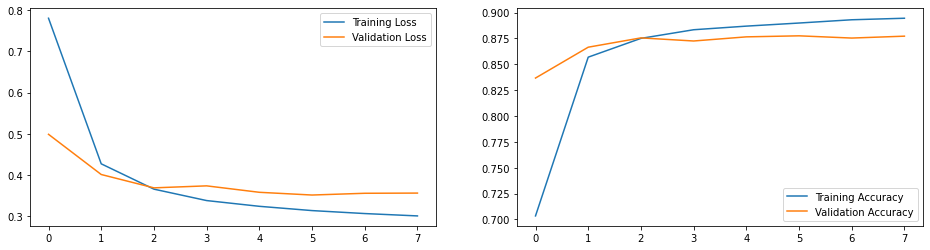

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
## create model with endcoder 12

In [ ]:
num_classes = 4
model12 = tf.keras.Sequential([
                              encoder12
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model12.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history12 = model12.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 369s 201ms/step - loss: 0.7239 - accuracy: 0.7264 - val_loss: 0.4722 - val_accuracy: 0.8393
Epoch 2/200
1782/1782 [==============================] - 355s 199ms/step - loss: 0.4283 - accuracy: 0.8534 - val_loss: 0.4255 - val_accuracy: 0.8557
Epoch 3/200
1782/1782 [==============================] - 353s 198ms/step - loss: 0.3857 - accuracy: 0.8665 - val_loss: 0.3993 - val_accuracy: 0.8603
Epoch 4/200
1782/1782 [==============================] - 353s 198ms/step - loss: 0.3648 - accuracy: 0.8733 - val_loss: 0.3889 - val_accuracy: 0.8648
Epoch 5/200
1782/1782 [==============================] - 353s 198ms/step - loss: 0.3527 - accuracy: 0.8769 - val_loss: 0.3891 - val_accuracy: 0.8670
Epoch 6/200
1782/1782 [==============================] - 355s 199ms/step - loss: 0.3396 - accuracy: 0.8813 - val_loss: 0.3759 - val_accuracy: 0.8670
Epoch 7/200
1782/1782 [==============================] - 353s 198ms/step - loss: 0.3278 - accuracy: 0.8853

In [ ]:
test_loss, test_acc = model12.evaluate(test_dataset)

119/119 [==============================] - 5s 45ms/step - loss: 0.3657 - accuracy: 0.8755


In [ ]:
history_dict = history12.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.365,0.873,0.389,0.865
4,0.353,0.877,0.389,0.867
5,0.340,0.881,0.376,0.867
6,0.328,0.885,0.373,0.870
7,0.320,0.887,0.362,0.872
8,0.311,0.891,0.363,0.876
9,0.304,0.893,0.356,0.874
10,0.299,0.894,0.356,0.877
11,0.294,0.897,0.361,0.872
12,0.289,0.898,0.370,0.873


In [ ]:
losses = history12.history['loss']
accs = history12.history['accuracy']
val_losses = history12.history['val_loss']
val_accs = history12.history['val_accuracy']
epochs = len(losses)

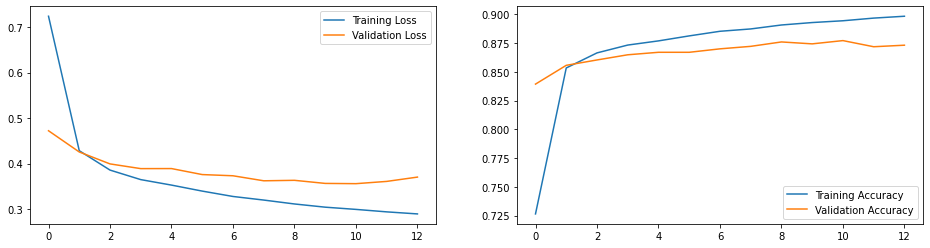

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
model_name =['model1','model2','model3','model4','model5','model6','model7','model8','model9','model10','model11','model12']
model_descr =['1000 vocabulary size, no edit of vocabulary, default output sequence length',
              '1000 vocabulary size, no edit of vocabulary, arbitary(128) output sequence length',
              '1000 vocabulary size, customized vocabulary, default output sequence length',
              '1000 vocabulary size, customized vocabulary, arbitary(128) output sequence length',
              '2000 vocabulary size, no edit of vocabulary, default output sequence length',
              '2000 vocabulary size, no edit of vocabulary, arbitary(128) output sequence length',
              '2000 vocabulary size, customized vocabulary, default output sequence length',
              '2000 vocabulary size, customized vocabulary, arbitary(128) output sequence length',
              '3000 vocabulary size, no edit of vocabulary, default output sequence length',
              '3000 vocabulary size, no edit of vocabulary, arbitary(128) output sequence length',
              '3000 vocabulary size, customized vocabulary, default output sequence length',
              '3000 vocabulary size, customized vocabulary, arbitary(128) output sequence length']

In [ ]:
perf_dict = { 'model' : model_name,
              'description': model_descr,
              'test_accuracy': test_accuracy
}

df_perf = pd.DataFrame(perf_dict)
print(df_perf)

      model                                        description  test_accuracy
0    model1  1000 vocabulary size, no edit of vocabulary, d...       0.847368
1    model2  1000 vocabulary size, no edit of vocabulary, a...       0.849342
2    model3  1000 vocabulary size, customized vocabulary, d...       0.846053
3    model4  1000 vocabulary size, customized vocabulary, a...       0.853816
4    model5  2000 vocabulary size, no edit of vocabulary, d...       0.879605
5    model6  2000 vocabulary size, no edit of vocabulary, a...       0.878684
6    model7  2000 vocabulary size, customized vocabulary, d...       0.857237
7    model8  2000 vocabulary size, customized vocabulary, a...       0.865526
8    model9  3000 vocabulary size, no edit of vocabulary, d...       0.885658
9   model10  3000 vocabulary size, no edit of vocabulary, a...       0.886184
10  model11  3000 vocabulary size, customized vocabulary, d...       0.877763
11  model12  3000 vocabulary size, customized vocabulary, a...  

In [ ]:
df_perf['vocab_size'] = 0
df_perf['edited'] = 0
df_perf['output sequence length'] = 0

In [ ]:
for i, desc in enumerate(model_descr):
  df_perf.loc[i, 'vocab_size'] = desc.split(',')[0]
  df_perf.loc[i,'edited'] = desc.split(',')[1]
  df_perf.loc[i,'out sequence length'] = desc.split(',')[2]

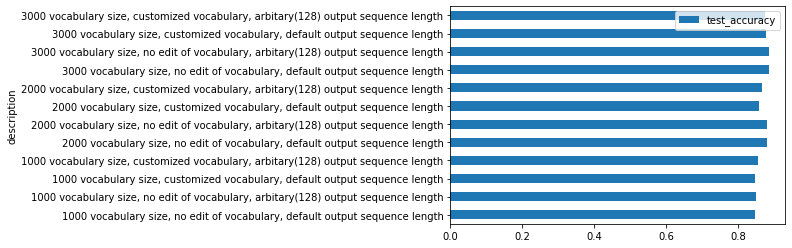

In [ ]:
df_perf.plot.barh(x='description', y='test_accuracy')

In [ ]:
df_vol = df_perf.groupby('vocab_size').test_accuracy.agg('mean')

print(df_vol)

vocab_size
1000 vocabulary size    0.849145
2000 vocabulary size    0.870263
3000 vocabulary size    0.881283
Name: test_accuracy, dtype: float64


In [ ]:
df_edit = df_perf.groupby('edited').test_accuracy.agg('mean')

print(df_edit)

edited
 customized vocabulary    0.862654
 no edit of vocabulary    0.871140
Name: test_accuracy, dtype: float64


In [ ]:
df_output_sequence_length = df_perf.groupby('out sequence length').test_accuracy.agg('mean')

print(df_output_sequence_length)

out sequence length
 arbitary(128) output sequence length    0.868180
 default output sequence length          0.865614
Name: test_accuracy, dtype: float64


In [ ]:
%%shell
jupyter nbconvert --to html /content/gdrive/MyDrive/MSDS458/Liu_Assignment2_MSDS458_2.ipynb